## Yennie Jun Fundamentals of Social Data Science Summative

TODO Justify all of the decisions you make for what data you decide
I would prefer more discussion of data quality and why some data were included or not than a discussion of complex modelling which you should probably save for your stats cours

# Part 1

## Introduction

The United States and South Korea noted their first case of the COVID-19 virus on January 20, 2020 (Holshue, 2020; Lim, 2020). The two countries responded to the virus in different ways. South Korea responded quickly with a proactive government response, combining rigorous contact tracing, early isolation, and free treatment of positive cases (Lee, 2020). The United States, on the other hand, had a delayed and disorganized response, disbanding the Pandemic Emergency Response Task Force and pushing the responsibility containment and mitigation strategies to individual states (Florida Atlantic University, 2020). 

These different responses led to each country having vastly different experiences with the virus. South Korea flattened the curve within weeks, emerging as a "model to emulate in fighting the pandemic" (You, 2020). On the other hand, the United States has emerged as the epicenter of the virus, boasting an exponentially increasing trajectory of infection cases (Balogun, 2020). To date, the US has experienced over ten million total cases and over 200,000 deaths related to the virus. In August, the US was found to account for 25 percent of COVID-19 cases and deaths in the world while comprising less than 5% of the global population (Florida Atlantic University, 2020). 

In this first section, I examine how fast the South Korean and United States governments responded after the first case of COVID-19 (January 20, 2020), with respect to different government response indicators. A comparison of the South Korean and United States' government responses is especially compelling because the two countries had the same date of first COVID-19 infection, and yet the former is viewed as a "success" story while the latter is viewed more as a "failure." The literature mentions that the South Korean government responded quickly, while the US government's response saw more delays, but I would like to quantify that amount. I inquire as to whether faster government response leads to a more successful COVID-19 containment response, at least in the context of these two countries. 



## Data Analysis

The government response indicators used in this paper are derived from the Oxford COVID-19 Government Response Tracker (Mahdi et al, 2020). More details about the specific indicators are listed in the [GitHub codebook](https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/codebook.md) in the `government response` table (Codebook, 2020). In this paper, I look specifically at the "Containment and closure policies", which are the policies that mention closures of various institutions (i.e. schools, workplaces, public transportation, etc). 

I am interested in the initial response of the two countries' governments to COVID-19, and therefore query for all data from the `government_response` prior to May 1, 2020. I calculate the "days since first infection" by subtracting each "government response" entry from `2020-01-20`.

I extract the government flags that I am interested in, which are all of the flags that begin with `c` in the codebook. An example of this is `c1_school_closing`. Each flag can have multiple levels of restrictions; for example, `1` denotes recommended school closures, whereas `2` denotes required school closures. I calculate the first instance of each stringency level of government response for each of the specified government flags. Using this information, I calculate the number of days it respecitvely took the South Korean and US governments to respond.

In [100]:
import os
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import psycopg2
import re
from datetime import datetime

sns.set()
sns.set_style("white")

In [101]:
conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19',
    user='covid19',
    password='covid19')
cur = conn.cursor()

In [102]:
# load govtrack table for just the United States and Korea, for the first few months of covid
sql_command = """SELECT * FROM government_response\
    WHERE date < '2020-05-01' and (country = 'United States' or country='South Korea')\
    ORDER by date ASC"""
df_govtrack = pd.read_sql(sql_command, conn)

# convert to datetime
df_govtrack.date = pd.to_datetime(df_govtrack['date'])

# calculate the timedelta of each response to first covid case
df_govtrack['response_since_first_infection'] = df_govtrack['date'] - datetime(2020, 1, 20)

In [478]:
# extract each of the c_xxxx flags mentioned in the government response tracker
gov_flags = [re.search("c\d_[^flag]\w*", col).group() \
             for col in df_govtrack.columns if re.match("c\d_[^flag]\w*", col)]
display(gov_flags)

['c1_school_closing',
 'c2_workplace_closing',
 'c3_cancel_public_events',
 'c4_restrictions_on_gatherings',
 'c5_close_public_transport',
 'c6_stay_at_home_requirements',
 'c7_restrictions_on_internal_movement',
 'c8_international_travel_controls']

In [479]:
# Extend gov_flags to include other relevant column indexes that I am interested in looking at
gov_flags.extend(["date", "response_since_first_infection", "country"])

# Get the containment and closure policies on each row for each flag
df_melt = df_govtrack[gov_flags].sort_values(by="date")\
    .melt(id_vars=["date", "response_since_first_infection", "country"])\
    .dropna()

# Display just the last few elements
display(df_melt.tail(3))

,date,response_since_first_infection,country,variable,value
1933,2020-04-29,100 days,United States,c8_international_travel_controls,3
1934,2020-04-30,101 days,South Korea,c8_international_travel_controls,3
1935,2020-04-30,101 days,United States,c8_international_travel_controls,3


In [485]:
# Calculate the "first" instance of for each country for each restriction level
first_restrictions_by_country = df_melt[df_melt.value!=0]\
    .groupby(['variable', 'country', 'value']).first()

# Calculate the "first" instance of all restrictions (regardless of restriction stringency level)
first_restrictions_all_levels = df_melt[df_melt.value!=0].\
    groupby(['variable', 'country']).first().unstack()["response_since_first_infection"]
first_restrictions_all_levels["response_difference"] = \
    first_restrictions_all_levels["United States"] - first_restrictions_all_levels["South Korea"]

# Calculate the average "first instance" across all restrictions
first_restriction_average = df_melt[df_melt.value!=0].groupby(['variable', 'country']).first().unstack()\
    [["response_since_first_infection"]].mean().unstack(0)
first_restriction_average["avg_first_response_in_days"] = \
    first_restriction_average["response_since_first_infection"].dt.days

## Results

In `Figure 1.1` we can see a plot of overall government response of the two countries, captured by the `government_response_index` (an aggregate government response indicator calculated by OxCovid). We can see that South Korea takes government action a lot quicker than the US. In fact, the US does not seem to begin ramping up their response until early- to mid-March. 

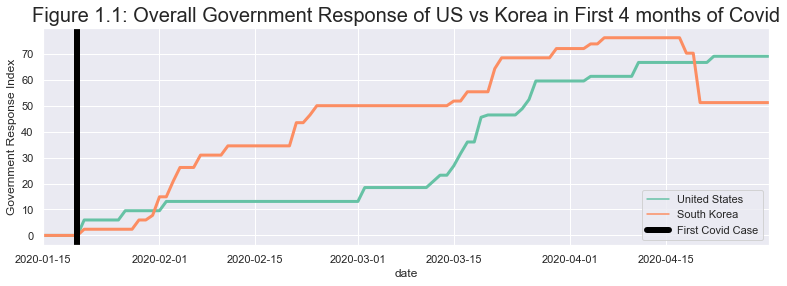

In [521]:
sns.set(rc={'figure.figsize':(13, 4)})

ax = sns.lineplot(data=df_govtrack, x="date", y="government_response_index", hue="country", palette="Set2", lw=3)

# Plot the "first day of contact"
ax.axvline(pd.to_datetime('2020-01-20'), color='black', lw=6, label="First Covid Case")

# Legends, titles, axes
plt.legend()
plt.ylabel('Government Response Index')
plt.xlim(pd.to_datetime('2020-01-15'), pd.to_datetime('2020-04-30'));
plt.title('Figure 1.1: Overall Government Response of US vs Korea in First 4 months of Covid', fontsize=20);

By grouping by government response variable and country, we can see the "first" day that each country's government started implementing a response, and also when the level of that response changed (`Figure 1.2`). We can see that in general, South Korea responded a lot earlier than the US did for nearly every category. Even as the level of restrictions within each category shifted,  South Korea's restriction levels tended to stay higher than the US's restriction levels.

In `Figure 1.3` we can see more of the details of restrictions of each country by restriction level. 

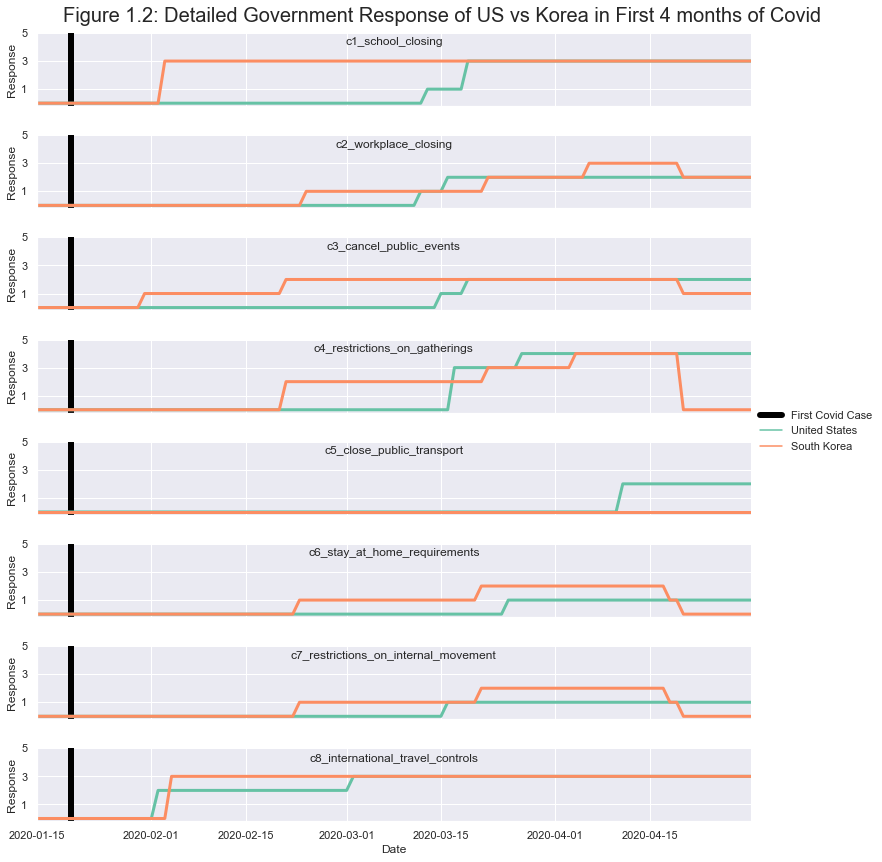

In [685]:
def add_line(**kwargs):
    plt.axvline(pd.to_datetime('2020-01-20'), lw=6, label="First Covid Case", **kwargs);

x_vars = "date"
y_vars = df_melt.variable.unique()

# Seaborn facetgrid for each variable
g = sns.FacetGrid(df_melt, col="variable", height=1.5, col_wrap=1, aspect=7)
# Add a line for the First Covid Case
g.map(add_line, color='black')

# Lineplot for each government response
g.map_dataframe(sns.lineplot, x="date", y="value", hue="country", palette="Set2", lw=3) 
g.set_axis_labels("Date", "Response") # Add axis labels
g.set(xlim=(pd.to_datetime('2020-01-15'), pd.to_datetime('2020-04-30')), yticks=[1,3,5])
g.set_titles(col_template="{col_name}", row_template="{row_name}", y=0.75) # Format subplot titles

# Add legends and titles
g.add_legend()
plt.subplots_adjust(top=0.95)
g.fig.suptitle('Figure 1.2: Detailed Government Response of US vs Korea in First 4 months of Covid', fontsize=20);

<span style="font-size:20px;">Figure 1.3: First Restrictions By Country and Restriction Level</span>

In [691]:
display(first_restrictions_by_country)

date  \
variable                             country       value              
c1_school_closing                    South Korea   3     2020-02-03   
                                     United States 1     2020-03-13   
                                                   3     2020-03-19   
c2_workplace_closing                 South Korea   1     2020-02-24   
                                                   2     2020-03-22   
                                                   3     2020-04-06   
                                     United States 1     2020-03-12   
                                                   2     2020-03-16   
c3_cancel_public_events              South Korea   1     2020-01-31   
                                                   2     2020-02-21   
                                     United States 1     2020-03-15   
                                                   2     2020-03-19   
c4_restrictions_on_gatherings        South Korea   2     2020-02-21   
                                                   3     2020-03-22   
                                                   4     2020-04-04   
                                     United States 3     2020-03-17   
                                                   4     2020-03-27   
c5_close_public_transport            United States 2     2020-04-11   
c6_stay_at_home_requirements         South Korea   1     2020-02-23   
                                                   2     2020-03-21   
                                     United States 1     2020-03-25   
c7_restrictions_on_internal_movement South Korea   1     2020-02-23   
                                                   2     2020-03-21   
                                     United States 1     2020-03-16   
c8_international_travel_controls     South Korea   3     2020-02-04   
                                     United States 2     2020-02-02   
                                                   3     2020-03-02   

                                                         response_since_first_infection  
variable                             country       value                                 
c1_school_closing                    South Korea   3                            14 days  
                                     United States 1                            53 days  
                                                   3                            59 days  
c2_workplace_closing                 South Korea   1                            35 days  
                                                   2                            62 days  
                                                   3                            77 days  
                                     United States 1                            52 days  
                                                   2                            56 days  
c3_cancel_public_events              South Korea   1                            11 days  
                                                   2                            32 days  
                                     United States 1                            55 days  
                                                   2                            59 days  
c4_restrictions_on_gatherings        South Korea   2                            32 days  
                                                   3                            62 days  
                                                   4                            75 days  
                                     United States 3                            57 days  
                                                   4                            67 days  
c5_close_public_transport            United States 2                            82 days  
c6_stay_at_home_requirements         South Korea   1                            34 days  
                                                   2                            61 days  
                       

In `Figure 1.4`, we can see that on average across all of the eight government response variables, the US took twice as long as Korea to respond.

In `Figure 1.5` (also visualized in `Figure 1.6`) we can see each government's response to each of the given government response indicators. For the purpose of this analysis, I have used the "first" response, regardless of its level of severity. 

From these figures, we can determine that although South Korea tended to respond anywhere from 17 to 39 days faster than the United States in terms of nearly all categories of government response, there are two exceptions. First, South Korea shows as having a null value for its response to public transportation. This is because South Korea indeed did not implement public transportation restrictions during the first few months of the COVID-19 pandemic, perhaps due to the fact that mask use was compulsory in public places (Tirachini, 2020).

Second, the only category in which the United States responded faster than South Korea was in "international travel controls." According to the US Department of State, President Trump issued the first COVID-19-related proclamation in January 31, 2020, which blocked entry into the US of foreigners who were present in China (Travel.state.gov., 2020). This proclamation went into effect on February 2.

<span style="font-size:20px;">Figure 1.4: Average First Restriction Response Per Country</span>

In [696]:
display(first_restriction_average[["avg_first_response_in_days"]])

,avg_first_response_in_days
country,
South Korea,25
United States,54


<span style="font-size:20px;">Figure 1.5: First Restrictions By Countries (For All Restriction Levels)</span>


In [693]:
display(first_restrictions_all_levels)

country,South Korea,United States,response_difference
variable,,,
c1_school_closing,14 days,53 days,39 days
c2_workplace_closing,35 days,52 days,17 days
c3_cancel_public_events,11 days,55 days,44 days
c4_restrictions_on_gatherings,32 days,57 days,25 days
c5_close_public_transport,NaT,82 days,NaT
c6_stay_at_home_requirements,34 days,65 days,31 days
c7_restrictions_on_internal_movement,34 days,56 days,22 days
c8_international_travel_controls,15 days,13 days,-2 days


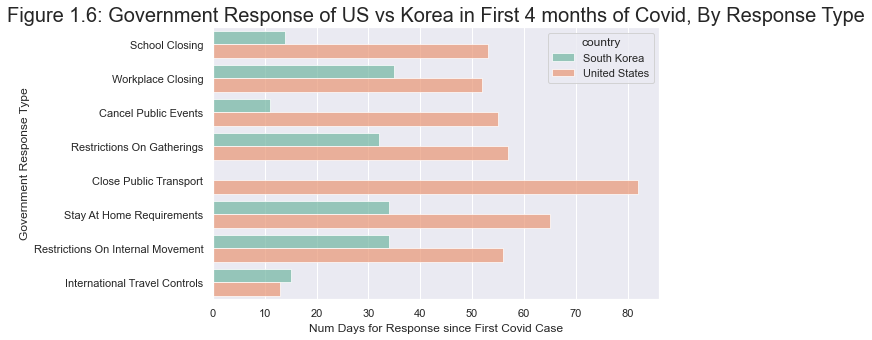

In [694]:
df_bar_data = df_melt[df_melt.value!=0].groupby(['variable', 'country']).first()\
    ["response_since_first_infection"].reset_index()

# Map days (datetime object) to integers
df_bar_data["response_since_first_infection"] = df_bar_data["response_since_first_infection"]\
    .apply(lambda a: a.days)

# Plot barplot
sns.set(rc={'figure.figsize':(8,5)})
g = sns.barplot(data=df_bar_data, y="variable", x="response_since_first_infection", alpha=0.7,
                hue="country", palette="Set2", orient='h', ci=False)

# Format the ticklabels to capitalize each word
g.set_yticklabels([' '.join([a.capitalize() for a in c.split('_')[1:]]) for c in df_melt.variable.unique()])

# Add labels and title
g.set_xlabel('Num Days for Response since First Covid Case')
g.set_ylabel('Government Response Type')
plt.title('Figure 1.6: Government Response of US vs Korea in First 4 months of Covid, By Response Type', fontsize=20);


## Discussion and Limitations

Overall, we can see that in nearly every category of government response, South Korea responded on average 25 days faster than the US did. In some cases (such as in enacting school closure restrictions), South Korea responded up to 39 days faster than the US did. As discussed above, there were only two areas in which this pattern did not hold. The first was in the case of public transportation, in which case South Korea did not enforce any restrictions at all, because they had no need to. In this case, having no response was a better indicator of COVID-19 success than having a stringent response. The second was in the case of international travel restrictions, in which the US responded swiftly and promptly (compared to their response in every other government response indicator).

Despite having the same first case of COVID-19, the difference in responses of the two governments is evident in the analysis that I have provided.

### Factors Not Included in this Analysis
However, before we jump to any conclusions about attributing South Korea's relative success dealing with COVID-19 to faster government response, it is important to take other factors into account. In this analysis, I did not investigate other factors that may have impacted the two governments' responses, such as increase in COVID-19 cases, the public government approval ratings, the propotion of elderly and vulnerable citizens in the population, and the country's history of past pandemics (for example, some scholars theorize that South Korea's experiences with MERS and SARS prompted a more swift response) [cite]. 

In this analysis, I also did not take into account the population size of the respective countries nor of their government structures. The US is a federal republic, meaning that responsibility and power is divided between the central government and the states. Individual states or local governments may have had earlier responses to the pandemic before the central government responded. While state-level and territory-level data is included in the government response table, local-level responses are likely to not be included (Hale et al, 2020)

Conversely, South Korea is a centralized democratic republic with a smaller population than the US. This difference in population size and centrality of the federal government probably had an effect on the various government responses to the pandemic as well.

One other limitation of this analysis comes in the later steps. In quantifying the "first response time", I did not take into account the level of severity of the actions. For example, the chart in `Figure 1.6` does not take into account that South Korea's first response to school closure was at a Level 3, while the US's first response to school closure was at a Level 1. While this was necessary for easy comparison, it is important to acknowledge the nuance lost by ignoring the stringency levels.


### Accuracy of Data
The government responses from the database are labeled as discrete values ranging on a scale from 0 to 3 or 4 (depending on the indicator). Because responses had to be mapped to these values, we lose a lot of nuance of type of response, since we do not know the details of what kind of response the government enacted. We only know the general level of stringency and category of the government response, but we do not know any details beyond that. Indeed, the Blavatnik School of Government (in charge of collecting this data) acknowledges in their working paper the challenges of measuring the diversity of governments' responses to COVID-19 in a systematic way, and of the abstraction of the nuances of these responses in using composite measures (Hale et al, 2020).

It is also important to acknowledge the likelihood of data inaccuracies in the OxCovid database government response indicators. It is inevitable that there will be inaccuracies, inconsistencies, or mistakes. The data in this table were manually collected by a team at Oxford via Internet searches of public news articles and government press releases (Hale et al, 2020). There are bound to be some inadvertent mistakes in the data.


### Future Directions

One future direction can be to include more details of the government responses beyond what is included in the government response table. For example, researchers can scrape the official announcements of the governments at the time of the "first" response and doing simple text analysis (sentiment analysis, topic modeling, or even simple Bag-of-Words) to quantify how these announcements align with the table. Another interesting analysis with this could involve seeing how these sentiments or topics change over time for each country, as more scientific research emerges about COVID-19 and as the severity of the global pandemic increases over time.

Another future direction for researchers could be to investigate the pandemic past the first 3-4 months (i.e. looking past May 1, 2020). Did these patterns of restrictions normalize over time between South Korea and the United States? Do they correlate with severity of COVID-19 cases or deaths?

# Part 2

## Introduction
As a continuation of Part 1, I wanted to examine government response time to "first case of Covid," but this time scaled to all countries. Different countries have had vastly different responses to Covid, and scholars have different theories about this. 

* What are good predictors for Covid response? https://ourworldindata.org/identify-covid-exemplars
* LSE saying that having more women leads to better covid response



The question I would like to answer in this part is: **Does the "regime type" of a government, as described by the Economist's Democracy Index, have an impact on a country's government response to enact restrictiosn in internal movements within the country?** That is, can a country's government (and the democracy level of that government) explain that country's willingness to impose stringent government controls?

* Ex: Philippines, China, really stringent approaches [cite]
* US really rolled their feet before having a lot of restrictions, and partially this is because a lot of Republicans are like freedom and shit [cite]
* This article argues that democracies responded better https://journals.sagepub.com/doi/full/10.1177/2319714520928884
* https://www.theatlantic.com/ideas/archive/2020/02/why-democracies-are-better-fighting-outbreaks/606976/ pro democracy
* lot of info here https://carnegieendowment.org/2020/03/31/do-authoritarian-or-democratic-countries-handle-pandemics-better-pub-81404 "Authoritarian and democratic governments both have mixed records when it comes to pandemic response"
* https://www.chathamhouse.org/2020/05/why-democracies-do-better-surviving-pandemics

I will be using the 2019democracy index calculated by the Economist Intelligence Unit (The Economist Intelligence Unit, 2019). I will have scraped it from Wikipedia, though. [cite... why? Is the EIU version different?]
* cite [this](https://www.semanticscholar.org/paper/Statistical-Classification-of-Democracy-Index-of-of-Bashar-Tsokos/c4df21e52c0225e0946321270d6bbc798f9f5924) and talk about some issues with democracy index

ClarifY: Why I need this data instead of API
Show that i am prioritizing my research goals
reflect on the fragility of this data

## Data Analysis

I'll be focusing on just the `c7_restrictions_on_internal_movements` flag. It can take the following values:
0 - no measures
1 - recommend not to travel between regions/cities
2 - internal movement restrictions in place
Blank - no data (Codebook)

I want to only look at restrictions at level "2" because they are stringent and 1 is just a recommendation

For the democracy index, I scraped from Wikipedia.
[This Github page](https://github.com/xmarquez/democracyData/blob/master/data-raw/EIU%20Democracy%20Index.csv) includes democracy index, but not the information about regime type, which is included in the EIU webpage (and their white paper). Therefore, I decided to scrape from Wikipedia because the Wikipedia page had some extra metadata about region of country and the regime type.



* Missing data from the OxCovid database: countries that are missing
* FYI: Leaving in NAs in the Government Response data ... doing that on purpose instead of replacing because then the average will be more accurate

In [730]:
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import psycopg2
import re
import datetime as dt
from bs4 import BeautifulSoup

sns.set()
sns.set_style("white")

In [732]:
conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19',
    user='covid19',
    password='covid19')
cur = conn.cursor()

In [11]:
# Scraping democracy index from Wikipedia page
response = requests.get("https://en.wikipedia.org/wiki/Democracy_Index")
soup = BeautifulSoup(response.text)

countries, scores, regimetypes, regions = [], [], [], []

for line in soup.find_all("table")[2].find_all("tr")[1:]:
    country = line.find("a").text
    score, regimetype = [a.text for a in line.find_all("b")]
    
    table_items = [t.text for t in line.find_all("td")]
    table_items = [i for i in table_items if 'Score:' not in i]
    
    countries.append(country)
    scores.append(score)
    regimetypes.append(regimetype)
    regions.append(table_items[-1].strip('\n'))

    # Last country in the table
    if country == "North Korea": break

In [12]:
# Convert democracy index lists into dataframe
dem_index = pd.DataFrame([countries, scores, regimetypes, regions]).T
dem_index.columns=["country", "dem_score", "regimetype", "region"]
dem_index.dem_score = dem_index.dem_score.apply(float)
display(dem_index.head())

,country,dem_score,regimetype,region
0,Norway,9.87,Full democracy,Western Europe
1,Iceland,9.58,Full democracy,Western Europe
2,Sweden,9.39,Full democracy,Western Europe
3,New Zealand,9.26,Full democracy,Asia & Australasia
4,Finland,9.25,Full democracy,Western Europe


In [736]:
# Load government tracking data from OX COVID
sql_command_all = """SELECT * FROM government_response\
    WHERE date < '2020-04-01'\
    ORDER by date ASC"""
df_govtrack_all = pd.read_sql(sql_command_all, conn)

# to datetime
df_govtrack_all.date = pd.to_datetime(df_govtrack_all['date'])
df_govtrack_all.government_response_index = df_govtrack_all.government_response_index.apply(float)

In [733]:
# Load epidemiology data from OX COVID
sql_command_epi = """SELECT * FROM epidemiology WHERE date < '2020-04-01' ORDER by date DESC"""
df_epidemiology = pd.read_sql(sql_command_epi, conn)

# to datetime
df_epidemiology.date = pd.to_datetime(df_epidemiology['date'])

In [737]:
# Determine "first case of covid" for each country
first_confirmed = df_epidemiology[df_epidemiology.confirmed>0]\
    .sort_values(by="date")[["country", "date", "confirmed", "gid"]]\
    .groupby("country")\
    .first()

# Extract GIDs from arrays for each row
first_confirmed.gid = first_confirmed.gid.dropna().apply(lambda x: x[0])

# Drop rows with null GIDs. These are continents (ex: Africa, America, etc)
first_confirmed = first_confirmed[~first_confirmed.gid.isna()]

# Some GIDs are have extra numbers after them, get rid of them (ex: POL.3.6_1)
first_confirmed.gid = first_confirmed.gid.apply(lambda x: re.search("(\w\w\w)",x).group(1))

In [738]:
# Selecting only "Restrictions on internal movement" government flag
gov_flags = ['c7_restrictions_on_internal_movement']
gov_flags.extend(["date", "country", "gid"])

# Dataframe with all of the government flags from above, melted
df_melt_all = df_govtrack_all[gov_flags]\
    .sort_values(by="date")\
    .melt(id_vars=["date", "country", "gid"])\
    .dropna()

# Merge in first confirmed date for each country
df_melt_all = df_melt_all.merge(first_confirmed, how="left", on=["gid"])\
    .rename(columns={"date_x": "date", "date_y": "first_confirmed_date"})\
    .drop(columns="confirmed")

# Calculate the number of days for each 
df_melt_all["response_since_first_infection"] = df_melt_all["date"] - df_melt_all["first_confirmed_date"]

In [741]:
display(df_melt_all[df_melt_all.value > 0].sample(5))

,date,country,gid,variable,value,first_confirmed_date,response_since_first_infection
17538,2020-03-27,Gambia,GMB,c7_restrictions_on_internal_movement,1.0,2020-03-17,10 days
17382,2020-03-26,United Arab Emirates,ARE,c7_restrictions_on_internal_movement,2.0,2020-01-27,59 days
15727,2020-03-18,France,FRA,c7_restrictions_on_internal_movement,2.0,2020-01-24,54 days
18278,2020-03-31,San Marino,SMR,c7_restrictions_on_internal_movement,1.0,2020-02-27,33 days
17265,2020-03-26,Mexico,MEX,c7_restrictions_on_internal_movement,1.0,2020-01-14,72 days


In [18]:
# The countries that do not seem to exist in the OxCovid database
df_melt_all[df_melt_all.first_confirmed_date.isna()].country.unique()

array(['Falkland Islands', 'Malawi', 'Vanuatu', 'Lesotho',
       'Solomon Islands', 'Tajikistan', 'Yemen', 'Turkmenistan',
       'Hong Kong', 'Macao', 'South Sudan', 'Pitcairn Islands'],
      dtype=object)

In [806]:
# Only looking at values that are above a 1 in score (i.e. most stringent scores)
# 1=Recommended, 2=Restricted
df_all_countries= df_melt_all[df_melt_all.value>1]\
    .groupby(['variable', 'country'])\
    .first()\
    .unstack()["response_since_first_infection"]\
    .melt()\
    .rename(columns={"value": "response_since_first_infection"})

# Extract just the number of "days" from the time detla
df_all_countries["response_since_first_infection"] = df_all_countries["response_since_first_infection"]\
    .apply(lambda a: a.days)

# Drop the countries with no data about confirmed cases
df_all_countries = df_all_countries[~df_all_countries["response_since_first_infection"].isna()]

# Merge back in the date of the first case of covid
df_all_countries = df_all_countries\
    .merge(first_confirmed.reset_index()[["country", "gid", "date"]], on="country")\
    .rename(columns={"date": "first_case"})

In [807]:
# Merge in democracy score
df_merge = df_all_countries.merge(dem_index, on="country")
display(df_merge.sample(5))

,country,response_since_first_infection,gid,first_case,dem_score,regimetype,region
12,Bosnia and Herzegovina,15.0,BIH,2020-03-05,4.86,Hybrid regime,Eastern Europe
36,Finland,58.0,FIN,2020-01-29,9.25,Full democracy,Western Europe
65,Mexico,76.0,MEX,2020-01-14,6.09,Flawed democracy,Latin America
6,Azerbaijan,19.0,AZE,2020-02-29,2.75,Authoritarian,Eastern Europe
63,Mali,0.0,MLI,2020-03-25,4.92,Hybrid regime,Sub-Saharan Africa


In [808]:
# Convert "first case" date to different time frames for extra analysis
df_merge['first_case_woy'] = df_merge.first_case.dt.isocalendar().week # week of year
df_merge['first_case_biweekly'] = df_merge.first_case_woy//2           # every [two weeks] of year
df_merge['first_case_month'] = df_merge.first_case.dt.month            # month of year
df_merge['first_case_ordinal'] = pd.to_datetime(df_merge['first_case'])\
    .apply(lambda date: date.toordinal())                               # date as ordinal

In [ ]:
# A ranking/ordering for regime type in order of authoritarian to democratic
regimetype_order = {"Authoritarian": 0, "Hybrid regime": 1, "Flawed democracy": 2, "Full democracy": 3}
df_merge["regimetype_order"] = df_merge.regimetype.map(regimetype_order)

## Results

We can see that some countries, like Mongolia, responded with strict internal movement restrictions **18 days** before their first Covid case (`Figure 2.1 (a)`). On the other end of the spectrum, Mexico responded with Level 2 stringent restrictions on internal movement 76 days after their first case (`Figure 2.1 (b)`). One pattern to note is that countries that responded faster with stringent measures of internal movement tended to have a later date for first COVID-19 case (mid- to late-March), whereas the countries that responded slower tended to have an earlier date for first COVID-19 case (mid- to late-January).

<span style="font-size:20px;">Figure 2.1 (a): Countries with fastest responses</span>


In [776]:
display(df_all_countries.sort_values(by='response_since_first_infection').head(10))

,country,response_since_first_infection,gid,first_case
74,Mongolia,-18.0,MNG,2020-03-10
48,Guatemala,-8.0,GTM,2020-03-14
66,Libya,-2.0,LBY,2020-03-24
91,Puerto Rico,-2.0,PRI,2020-03-14
50,Haiti,-1.0,HTI,2020-03-20
37,El Salvador,-1.0,SLV,2020-03-19
117,Venezuela,-1.0,VEN,2020-03-14
47,Greenland,0.0,GRL,2020-03-18
62,Kosovo,0.0,RKS,2020-03-13
20,Cape Verde,0.0,CPV,2020-03-20


<span style="font-size:20px;">Figure 2.1 (b): Countries with slowest responses</span>


In [777]:
display(df_all_countries.sort_values(by='response_since_first_infection').tail(10))

,country,response_since_first_infection,gid,first_case
69,Malaysia,53.0,MYS,2020-01-25
5,Australia,54.0,AUS,2020-01-25
19,Canada,54.0,CAN,2020-01-26
114,United Arab Emirates,56.0,ARE,2020-01-27
41,Finland,58.0,FIN,2020-01-29
77,Nepal,59.0,NPL,2020-01-23
102,South Korea,62.0,KOR,2020-01-19
115,United Kingdom,72.0,GBR,2020-01-11
107,Thailand,74.0,THA,2020-01-12
72,Mexico,76.0,MEX,2020-01-14


If we group solely by regime type, the data in `Figure 2.2` seem to be telling us something interesting. The more authoritarian the regime type of the government, the faster they tend to respond with stringent measures for internal movement. This seems to confirm our knowledge from the literature - authoritarian governments are likely to enact more restrictive measures, whereas democratic governments are likely to be more cognizant about citizens' privacy and freedom. But is it accurate to conclude that authoritarian governments tend to enact restrictive movement measures faster than democratic governments? 

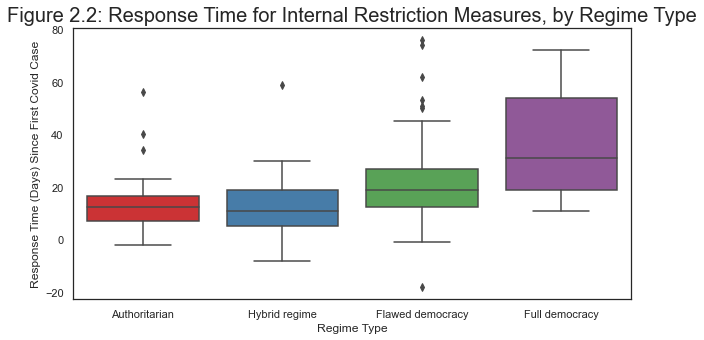

In [789]:
a4_dims = (10, 5)
fig, ax = plt.subplots(figsize=a4_dims)

g = sns.boxplot(ax=ax, x="regimetype", y="response_since_first_infection", 
                order=["Authoritarian", "Hybrid regime", "Flawed democracy", "Full democracy"],
                data=df_merge, palette="Set1")
plt.xlabel('Regime Type')
plt.ylabel('Response Time (Days) Since First Covid Case')
plt.title('Figure 2.2: Response Time for Internal Restriction Measures, by Regime Type', fontsize=20);

`Figure 2.3` confirms the intuition from `Figure 2.1`, that countries with faster response times tended to have later first cases of COVID-19. At least by first glance, democracy index does not seem to have much of an impact on determining a country's response to COVID-19. Perhaps the date of the first COVID-19 infection is more influential in determining a government's enactment of stringent internal restrictions, rather than their democracy score or regime type. 

In general, countries that experienced their first COVID-19 case before February 15, 2020 tended to respond faster than the countries with earlier first COVID-19 cases. There are a few outliers, and I have marked the names of the countries whose first case was before Feb 15, but they responded under 30 days. I have also marked the names of the countries that responded more than 1 day before their first case of COVID-19 infection.

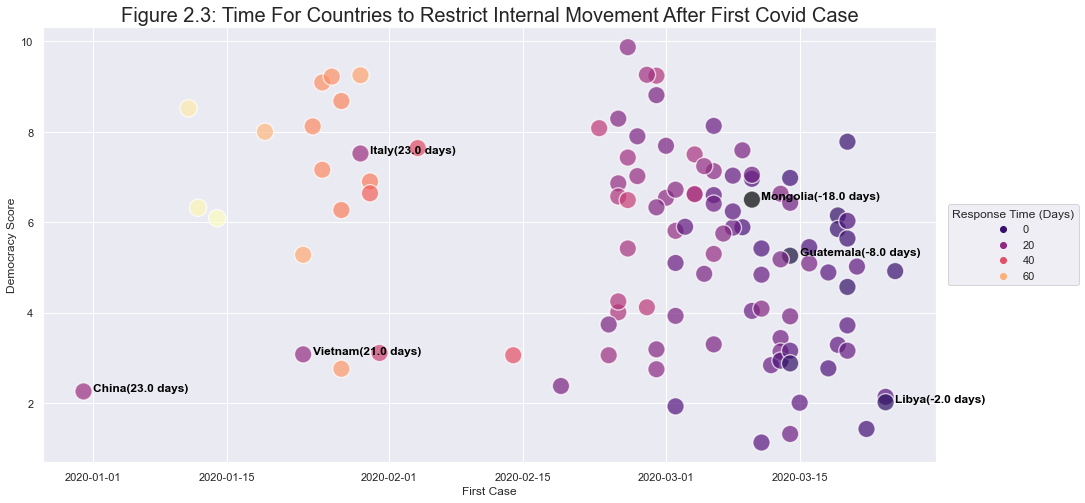

In [834]:
sns.set(rc={'figure.figsize':(16, 8)})

g = sns.scatterplot(data=df_merge, x="first_case", y="dem_score",
                hue="response_since_first_infection", s=300, alpha=.7, palette="magma")
plt.legend(bbox_to_anchor=(1.16, 0.5), loc='center right', borderaxespad=0.)

plt.xlabel('First Case')
plt.ylabel('Democracy Score')

# Add country labels for those who responded fast before February 15 
#   or responded more than 1 day before their first case of covid
for line in range(0,df_merge.shape[0]):
    label_country = (df_merge.first_case[line] < datetime(2020,2,15) \
                 and df_merge.response_since_first_infection[line] < 30) \
                or df_merge.response_since_first_infection[line] < -1
    if label_country:
        g.text(x=df_merge.first_case[line]+pd.DateOffset(hours=24), 
               y=df_merge.dem_score[line], 
               s=f"{df_merge.country[line]}({df_merge.response_since_first_infection[line]} days)", 
               horizontalalignment='left', 
               size='medium', 
               color='black', 
               weight='semibold')

leg = g.axes.get_legend()
leg.set_title("Response Time (Days)")
plt.title("Figure 2.3: Time For Countries to Restrict Internal Movement After First Covid Case", fontsize=20);


I combine both the influences of regime type (as a broader proxy of democracy index), the date of the first COVID-19 case, and the number of days it took to enact strict restrictions of internal movements. In  `Figure 2.4 (a)`, we can see the government response time, separated by regime type, with the date of the first COVID-19 case aggregated by month. `Figure 2.4 (b)` shows the same data, but aggregated at a biweekly scale (every two weeks).

We can see that for the countries with earlier first COVID-19 cases (i.e. before mid-February), authoritarian countries tended to respond a lot faster. We can also see that for the countries with later first COVID-19 dates (i.e. after mid-February), the regime type tended to have less of an influence in response time, as the data points were clustered more closer together.

In Figure `Figure 2.4 (c)`, we see the same information aggregated at a weekly scale (i.e. week of year), this time as a strip plot, and we can see that after week 8, the response time tends to be a lot more clustered and less variable.

Overall, it seems that the date of the first case of COVID-19 is very influential upon the number of days it took for the government to enact restrictions, although the regime type of that government is not negligible. 

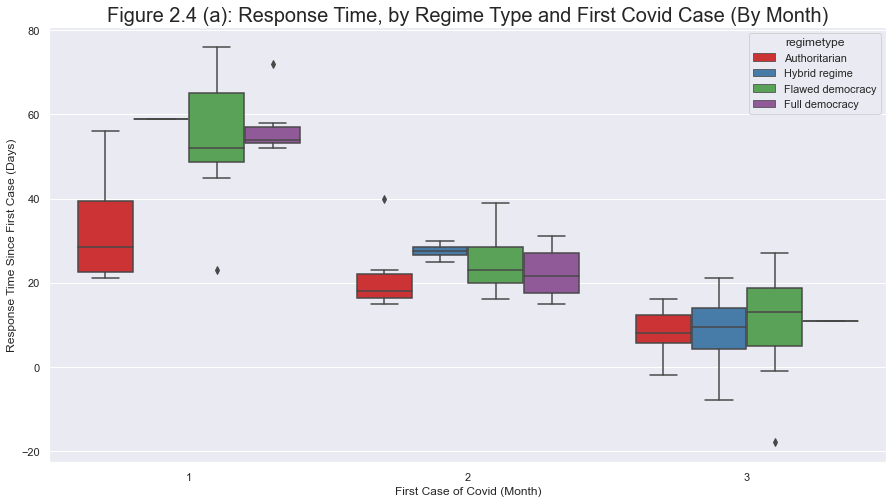

In [809]:
df_merge_months = df_merge.copy()

# Special case: China's first case was december 31, 2019. we will interpret this as january
df_merge_months.loc[df_merge_months.country=="China", "first_case_month"] = 1

a4_dims = (15, 8)
fig, ax = plt.subplots(figsize=a4_dims)
g = sns.boxplot(ax=ax, x="first_case_month", y="response_since_first_infection", hue="regimetype", 
                hue_order=["Authoritarian", "Hybrid regime", "Flawed democracy", "Full democracy"],
                data=df_merge_months, palette="Set1")
plt.xlabel('First Case of Covid (Month)')
plt.ylabel('Response Time Since First Case (Days)')
plt.title('Figure 2.4 (a): Response Time, by Regime Type and First Covid Case (By Month)', fontsize=20);

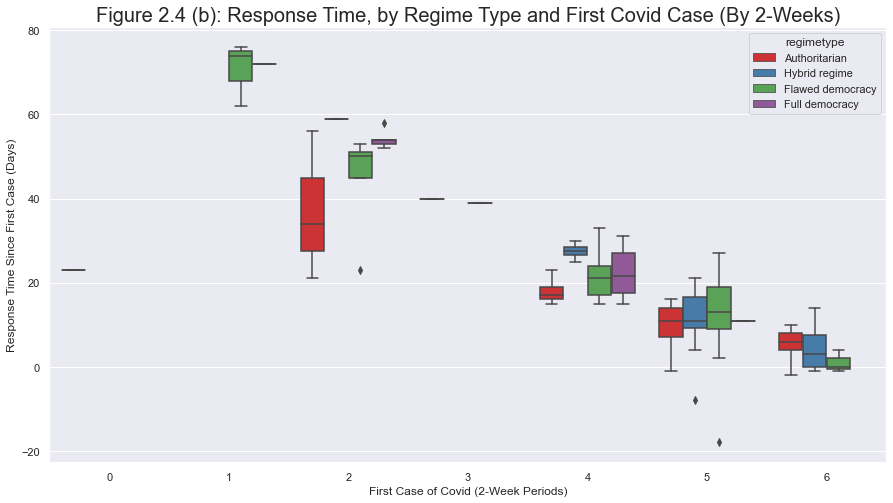

In [812]:
a4_dims = (15, 8)
fig, ax = plt.subplots(figsize=a4_dims)
g = sns.boxplot(ax=ax, x="first_case_biweekly", y="response_since_first_infection", hue="regimetype", 
                hue_order=["Authoritarian", "Hybrid regime", "Flawed democracy", "Full democracy"],
                data=df_merge, palette="Set1")
plt.xlabel('First Case of Covid (2-Week Periods)')
plt.ylabel('Response Time Since First Case (Days)')
plt.title('Figure 2.4 (b): Response Time, by Regime Type and First Covid Case (By 2-Weeks)', fontsize=20);

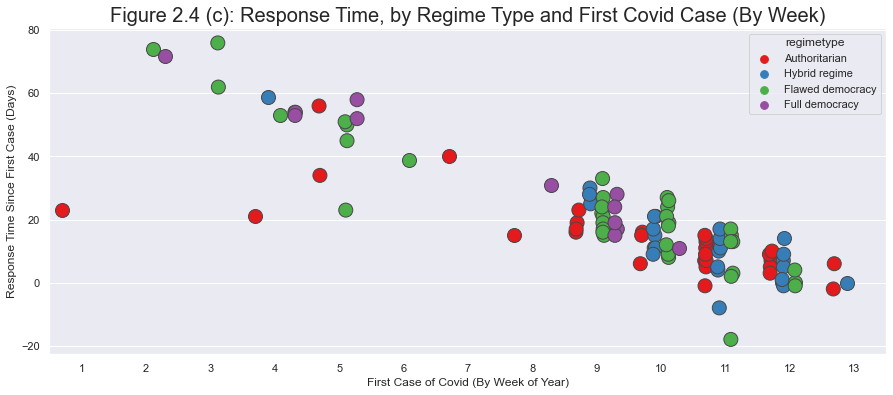

In [813]:
sns.set(rc={'figure.figsize':(15, 6)})

sns.stripplot(x="first_case_woy", y="response_since_first_infection", hue="regimetype", dodge=True, 
                zorder=1, size=14, linewidth=1,
                hue_order=["Authoritarian", "Hybrid regime", "Flawed democracy", "Full democracy"],
                data=df_merge_months, palette="Set1")
plt.xlabel('First Case of Covid (By Week of Year)')
plt.ylabel('Response Time Since First Case (Days)')
plt.title('Figure 2.4 (c): Response Time, by Regime Type and First Covid Case (By Week)', fontsize=20);

In Figure 2.4 we can see

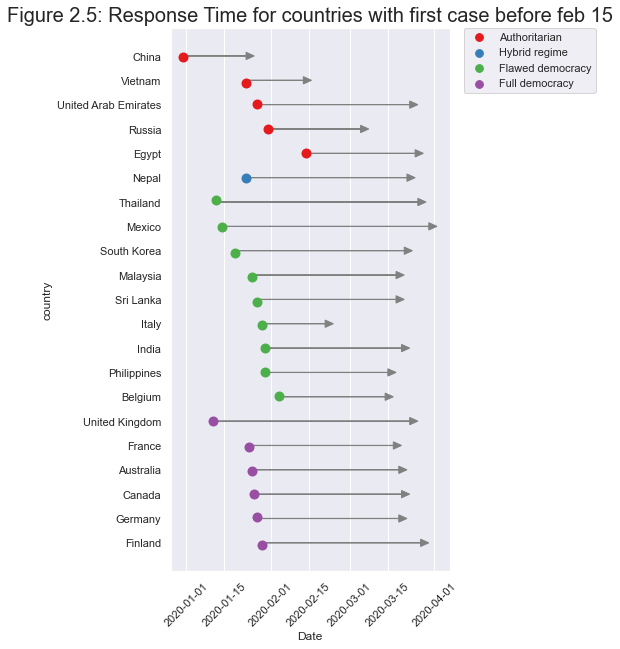

In [823]:
# plotting inspired by https://nikkimarinsek.com/blog/how-to-make-an-arrow-plot
ax = plt.figure(figsize=(5,10))

data = df_merge[df_merge.first_case < datetime(2020,2,15)].sort_values(by=["regimetype_order", "first_case"]).reset_index()

#add start points
ax = sns.stripplot(data=data, 
                   x='first_case', 
                   y='country', 
                   orient='h', 
                   hue='regimetype',
                   hue_order=["Authoritarian", "Hybrid regime", "Flawed democracy", "Full democracy"],
                   size=10,
                   palette='Set1',
                  )
arrow_starts = data['first_case'].values
arrow_lengths = data['response_since_first_infection']

#add arrows to plot
for i, subject in enumerate(data['country']):
    ax.arrow(arrow_starts[i],        #x start point
             i,                      #y start point
             arrow_lengths[i],       #change in x 
             0,                      #change in y
             head_width=.3,         #arrow head width
             head_length=3,        #arrow head length
             width=0.01,              #arrow stem width
             fc='gray',             #arrow fill color
             ec='gray')             #arrow edge color

plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Date')
plt.title('Figure 2.5: Response Time for countries with first case before feb 15', fontsize=20);

In [683]:
df_merge[df_merge.first_case < datetime(2020,2,15)].groupby(["regimetype"]).mean()["response_since_first_infection"]

regimetype
Authoritarian       34.800000
Flawed democracy    52.555556
Full democracy      57.166667
Hybrid regime       59.000000
Name: response_since_first_infection, dtype: float64

## Discussion and Limitations

Conclusion:

* At first glance, it seemed like authoritarian countries responded faster than democratic countries. It seemed like  authoritarian countries (or, countries with low "democratic index" scores), responded quicker to Covid by enacting strict rules about internal movements. In some cases, it seemed like authoritarian countries were responding even BEFORE they had their first case. 
* However, once we divide up by period of First Covid Case, we can see that in fact, many of the authoritarian countries tended to have their first case later. It seems that with the original hypothesis, First Covid Case was a confounder
* We should recognize that a lot of small countries we might not expect to have responded fast, did so in fact
* On the other hand, we should not make broad claims or conclusions that authoritarian countries necessarily lead to faster response. In fact, the First Covid Case, as we have seen, seemed to have a larger impact.


again, i do not take into account the severity of covid 
maybe if covid wasn't severe (like in south korea), no need to have super stringent restrictions for internal movement
also, somewhere like mongolia responded super early... maybe it was the threat of being so CLOSE to china geographically 


Limitations:
* Of the Democracy Index -- cite this and talk about some issues with democracy index
* Of OxCovid Database, Government Indicator project, and its accuracy ... (mentioned earlier in Part 1). Inaccuracies with countries that don't publish their data or are as transparent with their data. In Part1, US and SK are pretty transparent with publishing their data, but hard to say now with so many countries... also with more countries more room for errors.
* Authoritarian governments may not publish their first date of covid might be wrong
* countires missing from oxcovid database
    'Falkland Islands', 'Malawi', 'Vanuatu', 'Lesotho',
       'Solomon Islands', 'Tajikistan', 'Yemen', 'Turkmenistan',
       'Hong Kong', 'Macao', 'South Sudan', 'Pitcairn Islands']

* Also I am not taking into account how BAD covid was... so maybe countries with worse cases had more restrictions. like south korea didn't have super hard restrictions maybe because ... they didn't need to 

# FUTURE WORK

Doing more of a rigorous statistical analysis 

# Works Cited

Codebook for the Oxford Covid-19 Government Response Tracker (2020). GitHub Repository. Retrieved November 18, 2020 from https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/codebook.md.

Balogun, J. A. (2020). Commentary: Lessons from the USA delayed response to the COVID-19 pandemic. African journal of reproductive health, 24(1), 14-21.

Florida Atlantic University. (2020, August 20). COVID-19: How South Korea prevailed while the United States failed. ScienceDaily. Retrieved November 13, 2020 from www.sciencedaily.com/releases/2020/08/200820102431.htm.

Thomas Hale, Sam Webster, Anna Petherick, Toby Phillips, and Beatriz Kira (2020). Oxford COVID-19 Government Response Tracker, Blavatnik School of Government.

Holshue, M.L., DeBolt, C., Lindquist, S., Lofy, K.H., Wiesman, J., Bruce, H., Spitters, C.L., Ericson, K., Wilkerson, S., Tural, A., Díaz, G.T., Cohn, A., Fox, L., Patel, A., Gerber, S., Kim, L., Tong, S., Lu, X., Lindstrom, S., Pallansch, M., Weldon, W., Biggs, H., Uyeki, T.M., & Pillai, S. (2020). First Case of 2019 Novel Coronavirus in the United States. The New England Journal of Medicine, 382, 929 - 936.

Lee, D., Heo, K., & Seo, Y. (2020). COVID-19 in South Korea: Lessons for developing countries. World Development, 135, 105057 - 105057.

Lim, J., Jeon, S., Shin, H.Y., Kim, M.J., Seong, Y.M., Lee, W.J., Choe, K.W., Kang, Y.M., Lee, B., & Park, S.J. (2020). Case of the Index Patient Who Caused Tertiary Transmission of Coronavirus Disease 2019 in Korea: the Application of Lopinavir/Ritonavir for the Treatment of COVID-19 Pneumonia Monitored by Quantitative RT-PCR. Journal of Korean Medical Science, 35.

Mahdi, A., Blaszczyk, P., Dlotko, P., Salvi, D., Chan, T., Harvey, J., Gurnari, D., Wu, Y., Farhat, A., Hellmer, N., Zarebski, A., Hogan, B., & Tarassenko, L. (2020). OxCOVID19 Database: a multimodal data repository for better understanding the global impact of COVID-19. medRxiv.

The Economist Intelligence Unit. (2019). Democracy Index 2019. [online] Available at: <https://www.eiu.com/topic/democracy-index> [Accessed 13 November 2020].

Tirachini, A., & Cats, O. (2020). COVID-19 and Public Transportation: Current Assessment, Prospects, and Research Needs. The Journal of Public Transportation, 22, 1.

Travel.state.gov. (2020). Presidential Proclamations On Novel Coronavirus. [online] Available at: <https://travel.state.gov/content/travel/en/News/visas-news/presidential-proclamation-coronavirus.html> [Accessed 29 November 2020].

You, J. (2020). Lessons From South Korea’s Covid-19 Policy Response. The American Review of Public Administration, 50, 801 - 808.